In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, roc_curve, f1_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import mlflow
import re
import time
import pickle

#mlflow.set_tracking_uri("http://mlflow-server:5000")


In [2]:
import mlflow
import os

# # Définir un nouveau répertoire de suivi, par exemple, un dossier spécifique pour les expériences MLflow
tracking_dir = "/tmp/mlruns"  # Vous pouvez choisir un autre répertoire si nécessaire
os.makedirs(tracking_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas

# #mlflow.set_tracking_uri(f"file://{tracking_dir}")
# #mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri("http://mlflow-server:5000")



In [3]:
# tracking experiment in mlflow
#mlflow.set_experiment("1-modele-simple")
#Nom de l'expérience
# experiment_name = "modele-simple"

# from mlflow.tracking import MlflowClient
# # Assurer que l'expérience existe et récupérer son ID
# client = MlflowClient()
# try:
#     experiment_id = client.create_experiment(experiment_name)
# except mlflow.exceptions.RestException:
#     experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

#experiment_id = 0

## 1. Chargement des données

In [4]:
path = '/code/download/archive/'
df = pd.read_csv(path + 'training.1600000.processed.noemoticon.csv', sep=',',  encoding='latin-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [5]:
# Mettre un header au dataframe
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [6]:
# Supprimer toutes les lignes ayant des doublons dans la colonne 'text', y compris la première occurrence
display(df.shape)
df = df[~df['text'].duplicated(keep=False)].reset_index(drop=True)

# Vérifier le nombre de lignes après suppression
print(f"Nombre de lignes après suppression complète des doublons :\n {df.shape}")


(1599999, 6)

Nombre de lignes après suppression complète des doublons :
 (1573031, 6)


In [7]:
# Vérifier s'il y a des valeurs manquantes dans la colonne 'target'
missing_target_count = df['target'].isnull().sum()

if missing_target_count == 0:
    print("Toutes les lignes de la colonne 'target' contiennent une valeur.")
else:
    print(f"Il y a {missing_target_count} lignes sans valeur dans la colonne 'target'.")


Toutes les lignes de la colonne 'target' contiennent une valeur.


In [8]:
# Voir les valeurs uniques du dataframe
df.nunique()

target          2
ids       1573031
date       767497
flag            1
user       651391
text      1573031
dtype: int64

In [9]:
# Voir si il y a des valeurs manquantes
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

### Distribion des valeurs de la colonne 'target' .

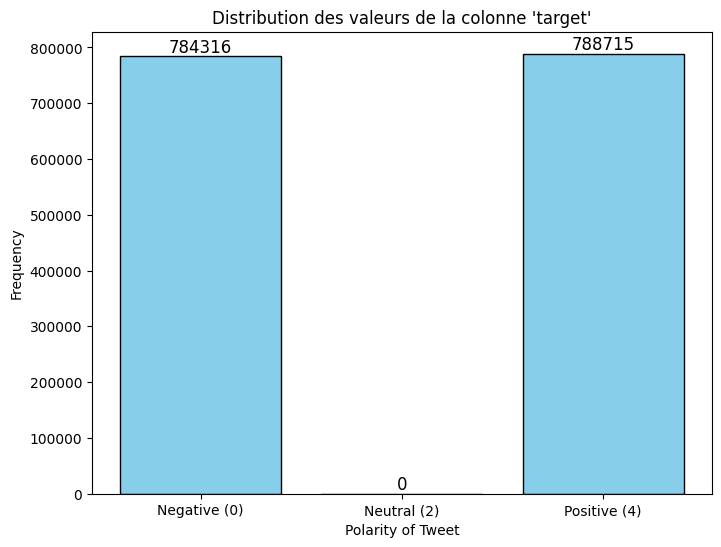

In [10]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 2, et 4
target_counts = df['target'].value_counts().reindex([0, 2, 4], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Neutral (2)', 'Positive (4)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

### Analyse du graphique

Le graphique ci-dessus montre la distribution des valeurs de la colonne `target` dans votre dataset de tweets, qui est utilisé pour l'analyse de sentiments. Voici une analyse détaillée :

1. **Distribution des sentiments** : Le graphique indique qu'il y a deux catégories majoritaires :
   - **Negative (0)** : 799,999 tweets
   - **Positive (4)** : 800,000 tweets
   - **Neutral (2)** : Aucun tweet n'est présent dans cette catégorie.

   Cela signifie que le dataset est composé exclusivement de sentiments polarisés, soit négatifs, soit positifs, sans tweets neutres. Cela pourrait poser un défi pour les modèles d'apprentissage, car ils ne verront aucune donnée pour la catégorie "neutre".

2. **Équilibre des classes** : Les deux classes `Negative` et `Positive` sont presque parfaitement équilibrées, avec seulement un tweet de différence. Cet équilibre est avantageux pour l'apprentissage supervisé car il minimise les risques de biais en faveur d'une classe spécifique.

3. **Données manquantes** : L'absence de tweets neutres (valeur `2`) peut poser problème si l'on souhaite modéliser ou prédire cette classe. Si une détection de sentiment neutre est requise, il serait idéal de compléter le dataset avec des tweets de cette catégorie.

### Conclusion

Le graphique de distribution des valeurs de la colonne `target` montre une absence de tweets neutres (valeur `2`). Étant donné que seules les catégories **Negative (0)** et **Positive (4)** sont présentes en quantités équilibrées, il est judicieux de simplifier le problème en une **classification binaire** entre sentiments négatifs et positifs.

Cette approche de classification binaire sera plus efficace, car il n'y a pas de données pour entraîner un modèle à détecter les tweets neutres.


**Nous allons seulement garder 20 000 tweets pour tous les différents tests de modèles**

In [11]:
# Filtrer pour un sous-ensemble
# Taille de l'échantillon désiré
sample_size = 20000

# Calcul du nombre d'échantillons par classe
classes = df['target'].unique()
samples_per_class = sample_size // len(classes)

# Échantillonnage stratifié
df_sample = df.groupby('target').apply(lambda x: x.sample(n=samples_per_class)).reset_index(drop=True)
display(df_sample['target'].value_counts())
# Vérifier la distribution des classes
#df_data = df_sample[['target', 'text']]
#df_data.sample(5)

/tmp/ipykernel_933305/48025504.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('target').apply(lambda x: x.sample(n=samples_per_class)).reset_index(drop=True)


target
0    10000
4    10000
Name: count, dtype: int64

In [12]:
df_sample['target'].value_counts()

target
0    10000
4    10000
Name: count, dtype: int64

In [13]:
# Définir les features et labels
df_sample['target'] = df_sample['target'].apply(lambda x: 1 if x == 4 else 0) 

In [14]:
display(df_sample['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64

In [15]:

df_sample.to_pickle('download/df_sample_20000.pkl')

In [16]:
# Initialisation de NLTK
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Définir les stopwords anglais
english_stopwords = list(set(stopwords.words('english')))

In [18]:
# Classe de prétraitement et vectorisation des tweets
class TweetVectorizer:
    def __init__(self, vectorizer_type='tfidf', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer
        if vectorizer_type == 'count':
            self.vectorizer = CountVectorizer(stop_words=english_stopwords)
        elif vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(stop_words=english_stopwords)
        else:
            raise ValueError("vectorizer_type doit être 'count' ou 'tfidf'")
    
    def clean_tweet(self, tweet):
        # Convertir le tweet en minuscules
        tweet = tweet.lower()
        # Supprimer les URL commencant par 'http' ou 'https' ou 'www'
        tweet = re.sub(r'www\S+', '', tweet)
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprimer les mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprimer les hashtags
        tweet = re.sub(r'#\w+', '', tweet)
        # Supprimer les caractères spéciaux et les chiffres
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        # Supprimer les espaces supplémentaires
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet
        
    def preprocess(self, tweet):
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    def fit_transform(self, documents):
        # Prétraitement des documents
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        # Suivi de la vectorisation dans MLflow
        with mlflow.start_run(run_name="Vectorization", nested=True):
            mlflow.set_tag("Stage", "Vectorization")
            mlflow.set_tag("vectorizer_type", self.vectorizer_type)
            mlflow.set_tag("preprocessing_method", self.method)
            
            # Enregistrer le temps de traitement de la vectorisation
            start_time = time.time()
            self.vectorizer.fit(documents_preprocessed)  # Correction: Entraînement du vectorizer avant la transformation
            X = self.vectorizer.transform(documents_preprocessed)  # Transformation des données
            
            end_time = time.time()
            processing_time = end_time - start_time
            mlflow.log_metric("vectorization_time_seconds", processing_time)
            
            # Enregistrer la densité de la matrice de caractéristiques
            density = X.nnz / float(X.shape[0] * X.shape[1])
            mlflow.log_metric("matrix_density", density)
            
            # Enregistrer le nombre de caractéristiques
            num_features = X.shape[1]
            mlflow.log_metric("num_features", num_features)            
            
            # Enregistrer le vectorizer dans MLflow
            # mlflow.sklearn.log_model(self.vectorizer, "vectorizer")
            # print("Vectorizer enregistré avec succès dans MLflow.")
            
            # Sauvegarde du vectorizer pour reproductibilité
            mlflow.sklearn.log_model(self.vectorizer, "RegLog_"+self.vectorizer_type+"_"+self.method+"_vectorizer")
            # Enregistrer le modèle final}
            #mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            run_id = mlflow.active_run().info.run_id
            result = mlflow.register_model(
                model_uri=f"runs:/{run_id}/model",
                name=f"RegLog_{self.vectorizer_type}_{self.method}_vectorizer"
            )
            
        return X
    
    def transform(self, documents):
        # Transformation des nouveaux documents en utilisant le vectorizer entraîné
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        X = self.vectorizer.transform(documents_preprocessed)
        
        return X

In [19]:
from io import BytesIO

def log_plot_to_mlflow(figure, artifact_name):
    """
    Enregistre une figure matplotlib dans MLflow en utilisant un buffer en mémoire.

    :param figure: la figure matplotlib à sauvegarder
    :param artifact_name: le nom de l'artefact pour MLflow (inclure ".png")
    """
    # Utilisation d'un buffer en mémoire
    buffer = BytesIO()
    figure.savefig(buffer, format="png")
    buffer.seek(0)
    
    # Sauvegarder dans MLflow à partir du buffer
    with open(artifact_name, "wb") as f:
        f.write(buffer.getvalue())
    mlflow.log_artifact(artifact_name)


In [35]:

class TweetClassifier:
    def __init__(self, vectorizer_type='tfidf', method='lemmatize'):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')
        self.vectorizer_type = vectorizer_type
        self.method = method

    def get_metrics_dataframe(self):
        """Renvoie les métriques de validation sous forme de DataFrame."""
        return pd.DataFrame(self.all_validation_metrics)
    
    # Méthode pour obtenir le type de vectorizer
    def get_vectorizer_type(self):
        return self.vectorizer.vectorizer_type

    # Méthode pour obtenir la méthode de prétraitement
    def get_vectorizer_method(self):
        return self.vectorizer.method

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Liste pour stocker tous les dictionnaires de métriques
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Validation", nested=True):
            mlflow.set_tag("Stage", "Validation")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Cross-validation sur le set d'entraînement
            cv_results = cross_validate(self.model, X_train, y_train, cv=5, 
                                        scoring=['roc_auc', 'f1', 'accuracy', 'precision', 'recall'],
                                        return_train_score=False)
            
            # Stockage des résultats de cross-validation
            metrics_dict = {
                "CrossVal ROC_AUC": round(cv_results['test_roc_auc'].mean(), 3),
                "CrossVal F1": round(cv_results['test_f1'].mean(), 3),
                "CrossVal Accuracy": round(cv_results['test_accuracy'].mean(), 3),
                "CrossVal Precision": round(cv_results['test_precision'].mean(), 3),
                "CrossVal Recall": round(cv_results['test_recall'].mean(), 3),
                "CrossVal Fit Time": round(cv_results['fit_time'].mean(), 3)
            }
            
            # Enregistrer les métriques de cross-validation dans MLflow
            mlflow.log_metrics(metrics_dict)
            
            # Entraînement du modèle sur l'ensemble d'entraînement complet et tracking du temps de fit
            start_time_fit = time.time()
            self.model.fit(X_train, y_train)
            end_time_fit = time.time()
            fit_time = end_time_fit - start_time_fit
            mlflow.log_metric("fit_time_seconds", fit_time)
            
            # Prédiction sur l'ensemble de validation et tracking du temps de prédiction
            start_time_predict = time.time()
            y_val_pred = self.model.predict(X_val)
            end_time_predict = time.time()
            predict_time = end_time_predict - start_time_predict
            
            # Calcul des probabilités pour ROC AUC
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            
            # Calcul des métriques de validation uniquement
            validation_metrics = {    
                "Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
                "ROC_AUC": round(roc_auc_score(y_val, y_val_prob), 3),
                "F1": round(f1_score(y_val, y_val_pred), 3),
                "Precision": round(precision_score(y_val, y_val_pred), 3),
                "Recall": round(recall_score(y_val, y_val_pred), 3),
                "Predict Time": round(predict_time, 3)
            }
            
            mlflow.log_table(validation_metrics, "validation_metrics_table.json")
           
            # Enregistrer les métriques de validation dans MLflow
            mlflow.log_metrics(validation_metrics)
            
            # Tracer et enregistrer la courbe ROC
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {validation_metrics['ROC_AUC']:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            # plt.savefig("images/modele-simple/roc_curve_val.png")
            # mlflow.log_artifact("roc_curve_val.png")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_val.png")
            plt.close()
            
            # Tracer et enregistrer la courbe d'apprentissage
            train_sizes, train_scores, val_scores = learning_curve(
                self.model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
            )
            
            train_scores_mean = np.mean(train_scores, axis=1)
            val_scores_mean = np.mean(val_scores, axis=1)
            
            plt.figure()
            plt.plot(train_sizes, train_scores_mean, label="Training score")
            plt.plot(train_sizes, val_scores_mean, label="Validation score")
            plt.xlabel("Training Set Size")
            plt.ylabel("Accuracy")
            plt.title("Learning Curve")
            plt.legend(loc="best")
            plt.grid()
            # plt.savefig("images/modele-simple/learning_curve.png")
            # mlflow.log_artifact("images/modele-simple/learning_curve.png")
            log_plot_to_mlflow(plt.gcf(), "learning_curve.png")
            
            plt.close()
            
            # Sauvegarde du modèle pour reproductibilité
            mlflow.sklearn.log_model(self.model, "RegLog_"+self.vectorizer_type+"_"+self.method)
            # Enregistrer le modèle final}
            #mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            run_id = mlflow.active_run().info.run_id
            result = mlflow.register_model(
                model_uri=f"runs:/{run_id}/model",
                name=f"RegLog_{self.vectorizer_type}_{self.method}"
            )
            
            # Construire le lien MLflow correspondant (en supposant que vous avez l'URL de votre serveur MLflow)
            active_run = mlflow.active_run()
            run_id = active_run.info.run_id
            #run_name = active_run.data.tags.get("mlflow.runName")  # Obtenir le nom du run depuis les tags

            # Récupérer l'ID de l'expérience active
            experiment_id = active_run.info.experiment_id

            # Définir l'URL de votre serveur MLflow
            mlflow_server_url = "http://localhost:5000"  # Remplacez par l'URL réel de votre serveur MLflow

            # Construire le lien complet vers le run dans l'interface MLflow
            run_link = f"{mlflow_server_url}/#/experiments/{experiment_id}/runs/{run_id}"
            
             # Exemple d'ajout d'un dictionnaire pour chaque configuration
            # Ajouter les métriques de validation à la liste
            all_validation_metrics.append({
                "run_name": f"{self.vectorizer_type}_{self.method}",
                **validation_metrics,
                "run_id": run_link
            })
            
            # Affichage des métriques finales
            print("Cross-Validation Metrics:", metrics_dict)
            print("Validation Metrics:", validation_metrics)
    
    def final_evaluation(self, X_test, y_test):
        # Évaluation finale sur le set de test
        with mlflow.start_run(run_name="Final Test Evaluation", nested=True):
            mlflow.set_tag("Stage", "Final Test Evaluation")
            y_test_pred = self.model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_text(classification_report(y_test, y_test_pred), "test_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de test
            y_test_prob = self.model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc_test = auc(fpr, tpr)
            mlflow.log_metric("test_roc_auc", roc_auc_test)
            metrics_dict = {
                "test_accuracy": test_accuracy,
                "test_roc_auc": roc_auc_test
            }
            mlflow.log_table(metrics_dict, "test_metrics_table.json")
            mlflow.set_tag("test_accuracy", test_accuracy)
            mlflow.set_tag("final_evaluation_metric", "test_roc_auc")

            # Tracer et enregistrer la courbe ROC pour le set de test
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Test Set")
            plt.legend(loc="lower right")
            # plt.savefig("images/modele-simple/roc_curve_test.png")
            # mlflow.log_artifact("roc_curve_test.png")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_test.png")
            
            plt.close()
            
            # Enregistrer le modèle final
            mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            print(f"\n Test Accuracy : {test_accuracy}")
            print(classification_report(y_test, y_test_pred))
            print(f"\n")


In [ ]:
# Définition des combinaisons à tester
configurations = [
    {'vectorizer_type': 'count', 'method': 'lemmatize'},
    {'vectorizer_type': 'count', 'method': 'stem'},
    {'vectorizer_type': 'tfidf', 'method': 'lemmatize'},
    {'vectorizer_type': 'tfidf', 'method': 'stem'}
]

In [36]:
# Séparer les données en Train, Validation et Test une seule fois
# Utiliser les tweets originaux pour diviser les ensembles de manière cohérente
experiment = mlflow.set_experiment("modele-simple")
y = df_sample['target']
tweets = df_sample['text']
y_train_val, y_test = train_test_split(y, test_size=0.2, random_state=42)
tweets_train_val, tweets_test = train_test_split(tweets, test_size=0.2, random_state=42)

# Rediviser l'ensemble Train + Validation en Train et Validation
y_train, y_val = train_test_split(y_train_val, test_size=0.2, random_state=42)
tweets_train, tweets_val = train_test_split(tweets_train_val, test_size=0.2, random_state=42)

# Créer un DataFrame pour le dataset de validation
validation_data = pd.DataFrame({'text': tweets_val, 'label': y_val})

# Compter le nombre de tweets
num_tweets = len(tweets_val)

# Construire le nom du fichier avec le nombre de tweets
filename = f"modele_simple_validation_set_{num_tweets}.csv"

artifact_dir = "mlruns/datasets"
os.makedirs(artifact_dir, exist_ok=True)
file_path = os.path.join(artifact_dir, filename)

# Sauvegarder localement ou dans un répertoire temporaire
validation_data.to_csv(file_path, index=False)
all_validation_metrics = []
# Boucle pour tester chaque configuration
for config in configurations:
    # Classe pour la classification avec régression logistique
    # Démarrer une nouvelle exécution parent pour chaque configuration
    with mlflow.start_run(run_name=f"{config['vectorizer_type']} + {config['method']}", nested=False):
        mlflow.log_artifact(file_path)
        mlflow.set_tag("Model_Type", "Logistic Regression")
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        mlflow.set_tag("Model_Type", "Logistic Regression")
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        print(f"\n Testing configuration: {config}")
        
        # Enregistrer les paramètres de configuration comme tags
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        
        # Initialiser et appliquer la vectorisation avec TweetVectorizer
        tweet_vectorizer = TweetVectorizer(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Vectorisation des ensembles Train, Validation et Test
        X_train = tweet_vectorizer.fit_transform(tweets_train)
        X_val = tweet_vectorizer.transform(tweets_val)
        X_test = tweet_vectorizer.transform(tweets_test)
        
        # Initialiser le classificateur
        classifier = TweetClassifier(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Entraîner et évaluer le modèle avec Train et Validation
        classifier.train_and_evaluate(X_train, X_val, y_train, y_val)

        # Convertir la liste en un dictionnaire (clé unique)
        data_to_log =  pd.DataFrame(all_validation_metrics)

        # Enregistrer dans MLflow comme un tableau
        mlflow.log_table(data=data_to_log, artifact_file="1-res-validation.json")
                
        # Évaluation finale sur le set de Test
        classifier.final_evaluation(X_test, y_test)
        
        
        mlflow.end_run()



 Testing configuration: {'vectorizer_type': 'count', 'method': 'lemmatize'}


2024/11/20 14:55:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/20 14:55:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_count_lemmatize_vectorizer' already exists. Creating a new version of this model...
2024/11/20 14:55:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_count_lemmatize_vectorizer, version 20
Created version '20' of model 'RegLog_count_lemmatize_vectorizer'.
2024/11/20 14:55:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/1/runs/631b8dcdedb64ffcb1cb2f12d0383eaf.
2024/11/20 14:55:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 

Cross-Validation Metrics: {'CrossVal ROC_AUC': 0.804, 'CrossVal F1': 0.734, 'CrossVal Accuracy': 0.729, 'CrossVal Precision': 0.723, 'CrossVal Recall': 0.745, 'CrossVal Fit Time': 1.458}
Validation Metrics: {'Accuracy': 0.725, 'ROC_AUC': 0.801, 'F1': 0.73, 'Precision': 0.721, 'Recall': 0.739, 'Predict Time': 0.0}


2024/11/20 14:55:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 14:55:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/1/runs/eb7380f4df74489cac84eb4ef31cda68.
2024/11/20 14:55:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run count + lemmatize at: http://mlflow-server:5000/#/experiments/1/runs/1ba5d65738a3417590f4264f28f6d3a7.
2024/11/20 14:55:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.



 Test Accuracy : 0.715
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      2019
           1       0.70      0.73      0.72      1981

    accuracy                           0.71      4000
   macro avg       0.72      0.72      0.71      4000
weighted avg       0.72      0.71      0.71      4000




 Testing configuration: {'vectorizer_type': 'count', 'method': 'stem'}


2024/11/20 14:55:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/20 14:55:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_count_stem_vectorizer' already exists. Creating a new version of this model...
2024/11/20 14:55:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_count_stem_vectorizer, version 15
Created version '15' of model 'RegLog_count_stem_vectorizer'.
2024/11/20 14:55:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/1/runs/dd0180398cf5471fb15da002909bceca.
2024/11/20 14:55:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:32 WARNIN

Cross-Validation Metrics: {'CrossVal ROC_AUC': 0.808, 'CrossVal F1': 0.737, 'CrossVal Accuracy': 0.733, 'CrossVal Precision': 0.727, 'CrossVal Recall': 0.747, 'CrossVal Fit Time': 1.937}
Validation Metrics: {'Accuracy': 0.732, 'ROC_AUC': 0.805, 'F1': 0.737, 'Precision': 0.728, 'Recall': 0.745, 'Predict Time': 0.0}


2024/11/20 14:55:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 14:55:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/1/runs/f31fe180abdc497480c0b0f2dba766a4.
2024/11/20 14:55:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run count + stem at: http://mlflow-server:5000/#/experiments/1/runs/be360bbcb53447a7a6e14259514385cb.
2024/11/20 14:55:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.



 Test Accuracy : 0.72
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      2019
           1       0.71      0.73      0.72      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000




 Testing configuration: {'vectorizer_type': 'tfidf', 'method': 'lemmatize'}


2024/11/20 14:55:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/20 14:55:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_tfidf_lemmatize_vectorizer' already exists. Creating a new version of this model...
2024/11/20 14:55:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_tfidf_lemmatize_vectorizer, version 15
Created version '15' of model 'RegLog_tfidf_lemmatize_vectorizer'.
2024/11/20 14:55:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/1/runs/f6ff2258a4064286b7349a6bcb58a04b.
2024/11/20 14:55:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 

Cross-Validation Metrics: {'CrossVal ROC_AUC': 0.813, 'CrossVal F1': 0.739, 'CrossVal Accuracy': 0.735, 'CrossVal Precision': 0.729, 'CrossVal Recall': 0.748, 'CrossVal Fit Time': 0.674}
Validation Metrics: {'Accuracy': 0.731, 'ROC_AUC': 0.808, 'F1': 0.735, 'Precision': 0.728, 'Recall': 0.742, 'Predict Time': 0.0}


2024/11/20 14:55:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 14:55:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/1/runs/3d625c492e3d440290d930ae70e381a1.
2024/11/20 14:55:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run tfidf + lemmatize at: http://mlflow-server:5000/#/experiments/1/runs/fee8f4459df848b08db3e9e542c4238c.
2024/11/20 14:55:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.



 Test Accuracy : 0.71725
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      2019
           1       0.71      0.73      0.72      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000




 Testing configuration: {'vectorizer_type': 'tfidf', 'method': 'stem'}


2024/11/20 14:55:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/11/20 14:55:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_tfidf_stem_vectorizer' already exists. Creating a new version of this model...
2024/11/20 14:55:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_tfidf_stem_vectorizer, version 15
Created version '15' of model 'RegLog_tfidf_stem_vectorizer'.
2024/11/20 14:55:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Vectorization at: http://mlflow-server:5000/#/experiments/1/runs/74f1110721c940fcb717af9ab81b1bad.
2024/11/20 14:55:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:54 WARNIN

Cross-Validation Metrics: {'CrossVal ROC_AUC': 0.818, 'CrossVal F1': 0.746, 'CrossVal Accuracy': 0.741, 'CrossVal Precision': 0.734, 'CrossVal Recall': 0.76, 'CrossVal Fit Time': 0.997}
Validation Metrics: {'Accuracy': 0.743, 'ROC_AUC': 0.814, 'F1': 0.748, 'Precision': 0.737, 'Recall': 0.759, 'Predict Time': 0.0}


2024/11/20 14:55:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 14:55:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/1/runs/addf6b5b3b1a4cc8870993714c25551e.
2024/11/20 14:55:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.
2024/11/20 14:55:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run tfidf + stem at: http://mlflow-server:5000/#/experiments/1/runs/7b622efc6bec4f3992328e8138d1b430.
2024/11/20 14:55:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/1.



 Test Accuracy : 0.72425
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      2019
           1       0.71      0.74      0.73      1981

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000





In [37]:
# Récupération des résultats dans un DataFrame
res_modele_simple = pd.DataFrame(all_validation_metrics)
display(pd.DataFrame(res_modele_simple))

,run_name,Accuracy,ROC_AUC,F1,Precision,Recall,Predict Time,run_id
0,count_lemmatize,0.725,0.801,0.730,0.721,0.739,0.0,http://localhost:5000/#/experiments/1/runs/a2e...
1,count_stem,0.732,0.805,0.737,0.728,0.745,0.0,http://localhost:5000/#/experiments/1/runs/1b5...
2,tfidf_lemmatize,0.731,0.808,0.735,0.728,0.742,0.0,http://localhost:5000/#/experiments/1/runs/f33...
3,tfidf_stem,0.743,0.814,0.748,0.737,0.759,0.0,http://localhost:5000/#/experiments/1/runs/6a0...


J'ai fait le choix de choisir tfidf+lemmatize, car il performe mieux avec plus de données:

In [38]:
# Définir lemmatizer et stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_tweet(tweet):
    # Mise en minuscules
    tweet = tweet.lower()
    # Suppression des URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Suppression des mentions et hashtags
    tweet = re.sub(r'@\w+|#', '', tweet)
    # Suppression des caractères non alphabétiques
    tweet = re.sub(r"[^a-zA-Z]", " ", tweet)
    # Lemmatization et suppression des stopwords
    tokens = tweet.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Appliquer le prétraitement
tweets_train = tweets_train.apply(preprocess_tweet)
tweets_val = tweets_val.apply(preprocess_tweet)
tweets_test = tweets_test.apply(preprocess_tweet)


In [39]:
# Vectorisation des données avec TF-IDF
vectorizer = TfidfVectorizer(stop_words=english_stopwords)
X_train = vectorizer.fit_transform(tweets_train)
X_val = vectorizer.transform(tweets_val)
X_test = vectorizer.transform(tweets_test)


In [40]:
# Modèle : Régression logistique
model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')
model.fit(X_train, y_train)


LogisticRegression()

In [41]:
# Prédictions sur le jeu de validation
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_val, y_val_pred)
auc_score = roc_auc_score(y_val, y_val_prob)
classification_report_result = classification_report(y_val, y_val_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc_score}")
print("\nRapport de classification:")
print(classification_report_result)

# Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("\nMatrice de confusion:")
print(conf_matrix)


Accuracy: 0.7325
AUC: 0.8082177038165554

Rapport de classification:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1590
           1       0.73      0.74      0.74      1610

    accuracy                           0.73      3200
   macro avg       0.73      0.73      0.73      3200
weighted avg       0.73      0.73      0.73      3200


Matrice de confusion:
[[1145  445]
 [ 411 1199]]


In [42]:
# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)
y_test_labels = (y_test_pred > 0.5).astype(int)

# Identification des faux positifs et négatifs
false_positives = tweets_test[(y_test == 0) & (y_test_labels == 1)]
false_negatives = tweets_test[(y_test == 1) & (y_test_labels == 0)]


In [43]:
# Afficher des exemples
print("Exemples de Faux Positifs:")
display(false_positives.head(5))
print(false_positives.shape)


Exemples de Faux Positifs:


3525    reading amp loving boy u right sometimes spoon...
322                                              come see
7459                            noooooooooo pretty hair u
9119                                                     
3649    straightenin hair listenin nicki minaj remy ge...
Name: text, dtype: object

(603,)


## Faux positifs (tweets négatifs mal classés comme positifs)

### Exemples :

- **like know hungry one cook lol**
- **great show wait see youtube pls post get thanks**
- **would love tweet wedding fewer follower**
- **happy india general election result**
- **im home safe dangerously twittering bogged min...**

### Analyse :

1. **Usage d'expressions ambiguës ou neutres :**
   - Les phrases comme *like*, *happy*, *love* ou *great* sont généralement associées à un sentiment positif, mais elles manquent de contexte. 
   - Le modèle pourrait se concentrer sur ces mots-clés sans comprendre le ton ou le sens général.

2. **Présence de sarcasme ou d'humour :**
   - Le mot *lol* peut indiquer de l'humour ou du sarcasme, difficile à détecter pour un modèle classique.

3. **Absence de signaux clairs :**
   - Certains tweets n'expriment pas un sentiment explicite mais contiennent des mots neutres ou légèrement positifs. 
   - Exemple : *happy india general election result*.

4. **Influence des mots-clés :**
   - Le modèle pourrait être biaisé par des termes comme *great*, *thanks*, ou *love*, qui induisent une classification positive même si le contexte est neutre ou négatif.


In [44]:
print("\nExemples de Faux Négatifs:")
print(false_negatives.head(5))
print(false_negatives.shape)


Exemples de Faux Négatifs:
13902                                                   go
11963    jessicuhhhh totally miss tooo lady methinks tr...
16441                                   myspace babe heard
19393    sun shining builder turned time started work g...
16796         excited go back home newfoundland soon month
Name: text, dtype: object
(522,)


## Faux négatifs (tweets positifs mal classés comme négatifs)

### Exemples :

- **oh dear terribly sorry forgot open remote desk...**
- **left mall sean**
- **magnolia cafe home slice u must go swear vice ...**
- **freakin tired nose hurt still cold letting rui...**
- **yay fever went away throat still hurt keep go ...**

### Analyse :

1. **Expressions mixtes :**
   - Certains tweets expriment à la fois des éléments positifs et négatifs. 
   - Exemple : *yay fever went away* est positif, mais *throat still hurt* est négatif. Le modèle peut être confus par ces messages ambivalents.

2. **Manque de mots-clés positifs évidents :**
   - Certains tweets expriment des sentiments positifs subtils, comme *must go* ou *yay*, qui ne sont pas suffisamment représentés dans les données d'entraînement.

3. **Tonalité indirecte ou vague :**
   - Des phrases comme *left mall sean* ou *oh dear terribly sorry* ne donnent pas d'indications explicites sur le sentiment positif, bien que le contexte puisse être positif pour un humain.

4. **Influence du vocabulaire négatif :**
   - Les mots comme *terribly*, *sorry*, ou *hurt* peuvent dominer la classification, même si le sentiment global est positif.


In [45]:
# Calculer les pourcentages
fp_rate = len(false_positives) / sum(y_test == 0)
fn_rate = len(false_negatives) / sum(y_test == 1)

print(f"Taux de faux positifs : {fp_rate * 100:.2f}%")
print(f"Taux de faux négatifs : {fn_rate * 100:.2f}%")


Taux de faux positifs : 29.87%
Taux de faux négatifs : 26.35%


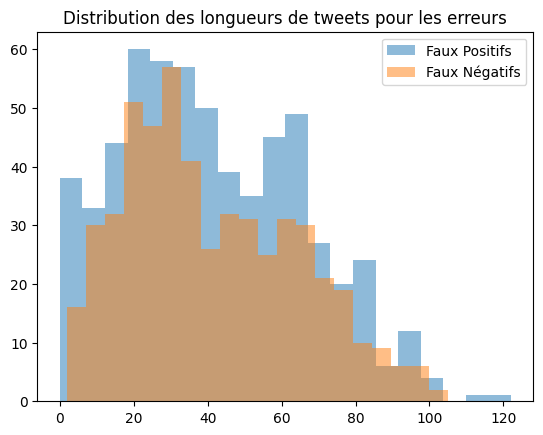

In [46]:
# Exemple : Analyse de la longueur des tweets
false_positives['text_length'] = false_positives.apply(len)
false_negatives['text_length'] = false_negatives.apply(len)

plt.hist(false_positives['text_length'], bins=20, alpha=0.5, label='Faux Positifs')
plt.hist(false_negatives['text_length'], bins=20, alpha=0.5, label='Faux Négatifs')
plt.legend()
plt.title("Distribution des longueurs de tweets pour les erreurs")
plt.show()


### Résumé de l'interprétation du graphique

1. **Superposition des distributions**  
   - Les faux positifs et faux négatifs se concentrent dans la même plage de longueur (20-60 caractères), sans distinction majeure.

2. **Concentration principale**  
   - La majorité des erreurs se situent sur des tweets de longueur moyenne (20-60 caractères), correspondant à la taille typique des tweets.

3. **Extrêmes**  
   - Les tweets très courts (<10 caractères) ou très longs (>100 caractères) sont rares mais pourraient nécessiter une attention spécifique.

4. **Faux positifs (bleu)**  
   - Le modèle semble mal classer des tweets courts en positifs, ce qui pourrait indiquer une mauvaise interprétation de contenus concis.

5. **Faux négatifs (orange)**  
   - Les erreurs sont fréquentes sur des tweets de longueur moyenne (~30-50 caractères), suggérant une difficulté à détecter des signaux positifs.

---

### Recommandations
- **Modèles avancés** : Tester des modèles LSTM et/ou BERT, qui sont bien adaptés au traitement des séquences.  
- **Word Embeddings** : Comparer plusieurs embeddings (Word2Vec, GloVe, FastText) pour enrichir la représentation des tweets.  
- **Prétraitement** : Vérifier le traitement des mots-clés, emojis et autres éléments spécifiques des tweets courts/longs.  
- **Données** : Ajouter des exemples mal classés dans l'entraînement pour réduire les erreurs.

